In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [2]:
#open the data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)
#our team
team = "England Women's"
#get list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_ team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)

## Finding Danger Passes.

1. For each period in the game we take out shots by England and accurate passes by england that were not set pieces.
2. We look for passes 15 seconds before a shot.
3. Having the danger passes we concatenate them with a pandas dataframe to store danger passes from all games.

In [4]:
# Declare an empty dataframe.
danger_passes = pd.DataFrame()

for idx in match_ids:
    # open the event data from this game.
    df = parser.event(idx)[0]
    for period in [1, 2]:
        # Keep only accurate passes by england that were not set pieces in this period.
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())

        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

        # Keep only shots by england in this period.
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)

        # Keep only necessary columns.
        shots = df.loc[mask_shot, ['minute', 'second']]

        # Convery time to seconds.
        shot_times = shots['minute'] * 60 + shots['second']

        # 15 seconds window from the shot.
        shot_window = 15

        # condition to avoid negative shot starts.
        shot_start = shot_times - shot_window
        shot_start = shot_start.apply(lambda x: x if x > 0 else (period - 1) * 45)

        # convert to seconds
        pass_times = passes['minute'] * 60 + passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

## Plotting location of danger passes.

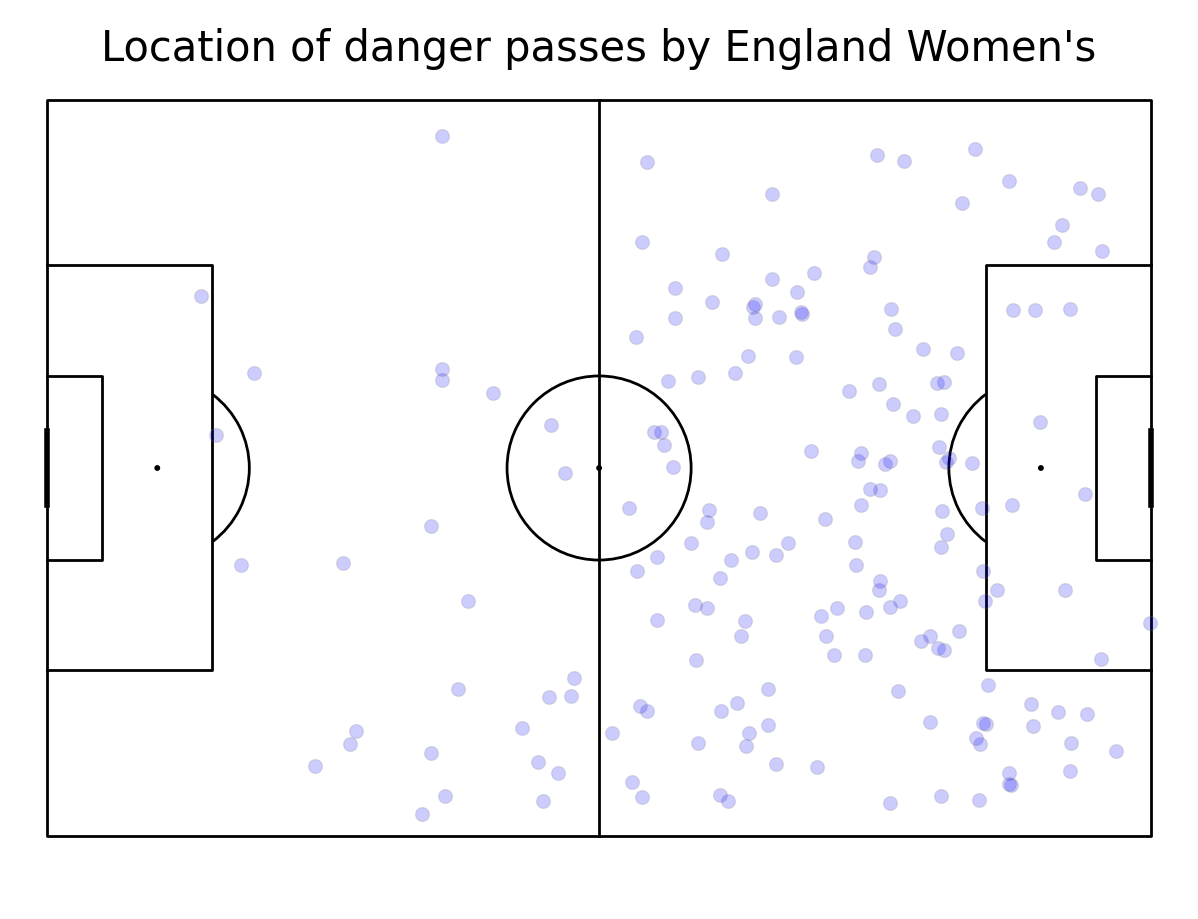

In [5]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

## Plotting a heatmap.

1. Draw a pitch.
2. Calculate the number of passes in each bin using bin_statistic method.
3. Normalize number of passes by number of games.
4. Plot a heatmap.
5. Make a legend
6. Add a title.

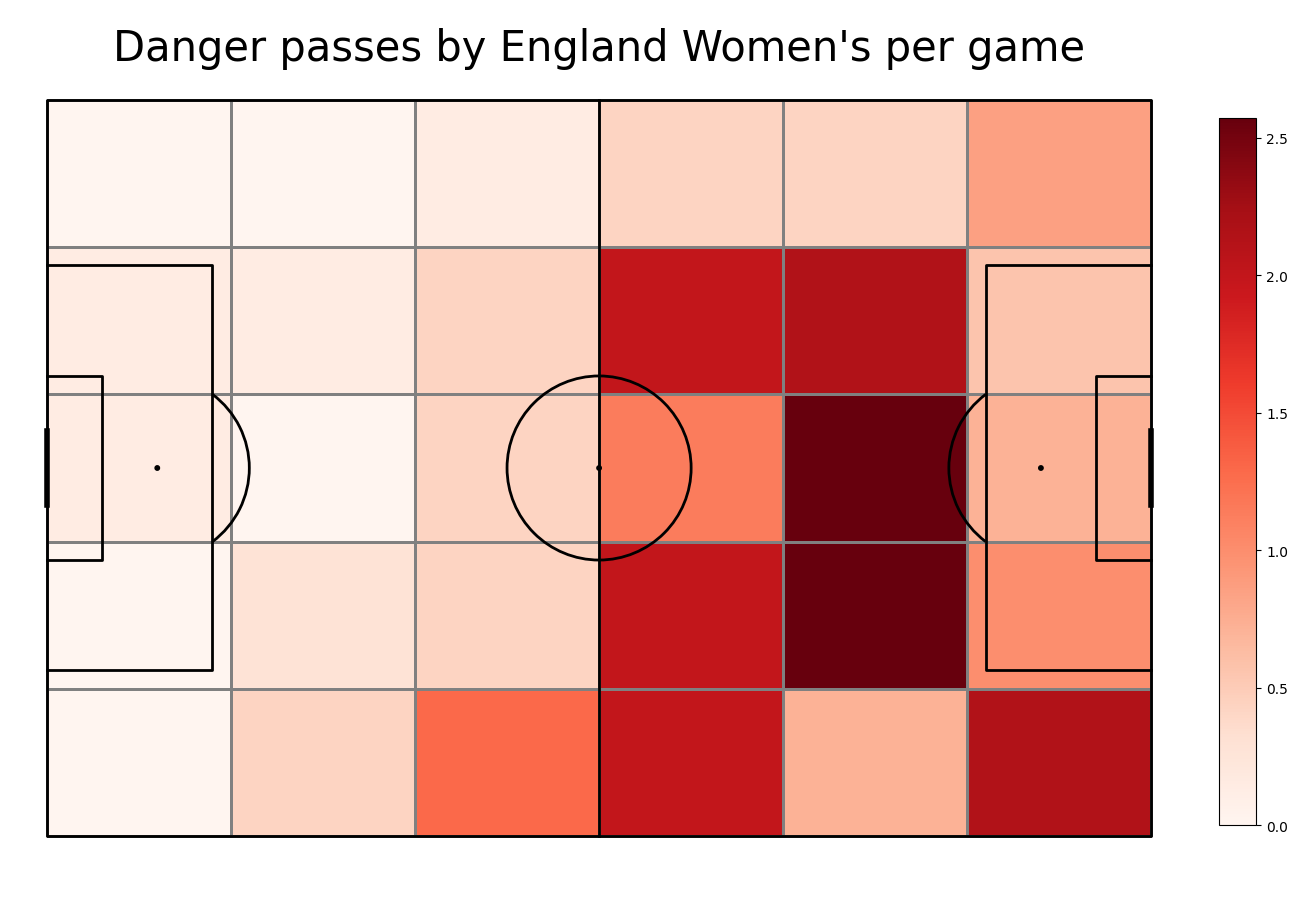

In [10]:
# Plot a vertical pitch.
pitch = Pitch(line_zorder=2, line_color='black')

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# get the 2D histogram.
bin_statistic = pitch.bin_statistic(
    danger_passes.x,
    danger_passes.y,
    statistic='count',
    bins=(6, 5),
    normalize=False
)

#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))

cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

## Making Diagrams of most involved players.

- To find out who was the most involved in danger passes, we keep only surnames of the players.
- We group the passes by player and count them.
- We divide them by number of games to keep diagrams per game.
- We make legend to our diagram.

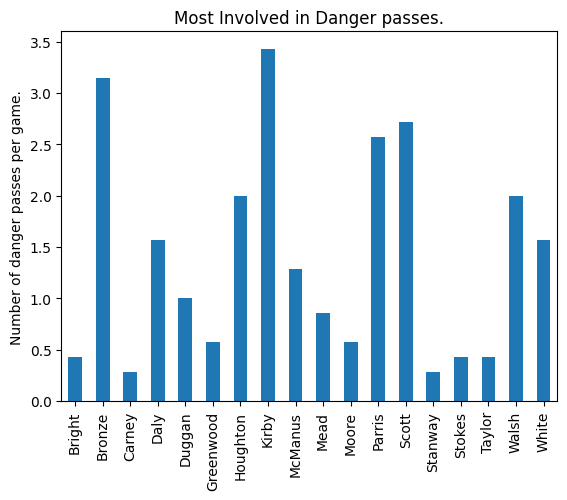

In [13]:
# Keep only surnames.
danger_passes['player_name'] = danger_passes['player_name'].apply(lambda x: str(x).split()[-1])

# count passes by player and normalize them.
pass_count = danger_passes.groupby(['player_name']).x.count()/no_games

# make a histogram.
ax = pass_count.plot.bar(pass_count)

# make legend.
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game.")
plt.title("Most Involved in Danger passes.")
plt.show()

## Challenge

1. Improve so that only high xG (>0.07) are included.
2. Make a heat map only for Sweden's player who was the most involved in danger passes.

### 1. Danger passes that lead to high xG shots (>0.07)

In [36]:
# Declare an empty dataframe.
danger_passes = pd.DataFrame()

for idx in match_ids:
    # open the event data from this game.
    df = parser.event(idx)[0]
    for period in [1, 2]:
        # Keep only accurate passes by england that were not set pieces in this period.
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())

        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name", ]]

        # Keep only shots by england in this period.
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period) & (df.shot_statsbomb_xg > 0.07)

        # Keep only necessary columns.
        shots = df.loc[mask_shot, ['minute', 'second']]

        # Convery time to seconds.
        shot_times = shots['minute'] * 60 + shots['second']

        # 15 seconds window from the shot.
        shot_window = 15

        # condition to avoid negative shot starts.
        shot_start = shot_times - shot_window
        shot_start = shot_start.apply(lambda x: x if x > 0 else (period - 1) * 45)

        # convert to seconds
        pass_times = passes['minute'] * 60 + passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [37]:
danger_passes

,x,y,end_x,end_y,minute,second,player_name
0,32.9,70.0,42.0,68.5,30,26,Stephanie Houghton
1,41.7,71.0,45.1,76.5,30,27,Jill Scott
2,53.9,76.2,67.0,62.0,30,30,Nikita Parris
3,70.4,54.9,85.1,66.2,30,32,Jill Scott
4,21.1,50.5,22.4,41.4,50,40,Lucy Bronze
...,...,...,...,...,...,...,...
93,99.1,57.7,102.0,43.4,91,4,Rachel Daly
94,79.2,72.2,67.0,70.5,18,29,Nikita Parris
95,70.7,69.9,71.3,59.6,18,31,Lucy Bronze
96,75.4,58.2,98.5,6.8,18,34,Keira Walsh


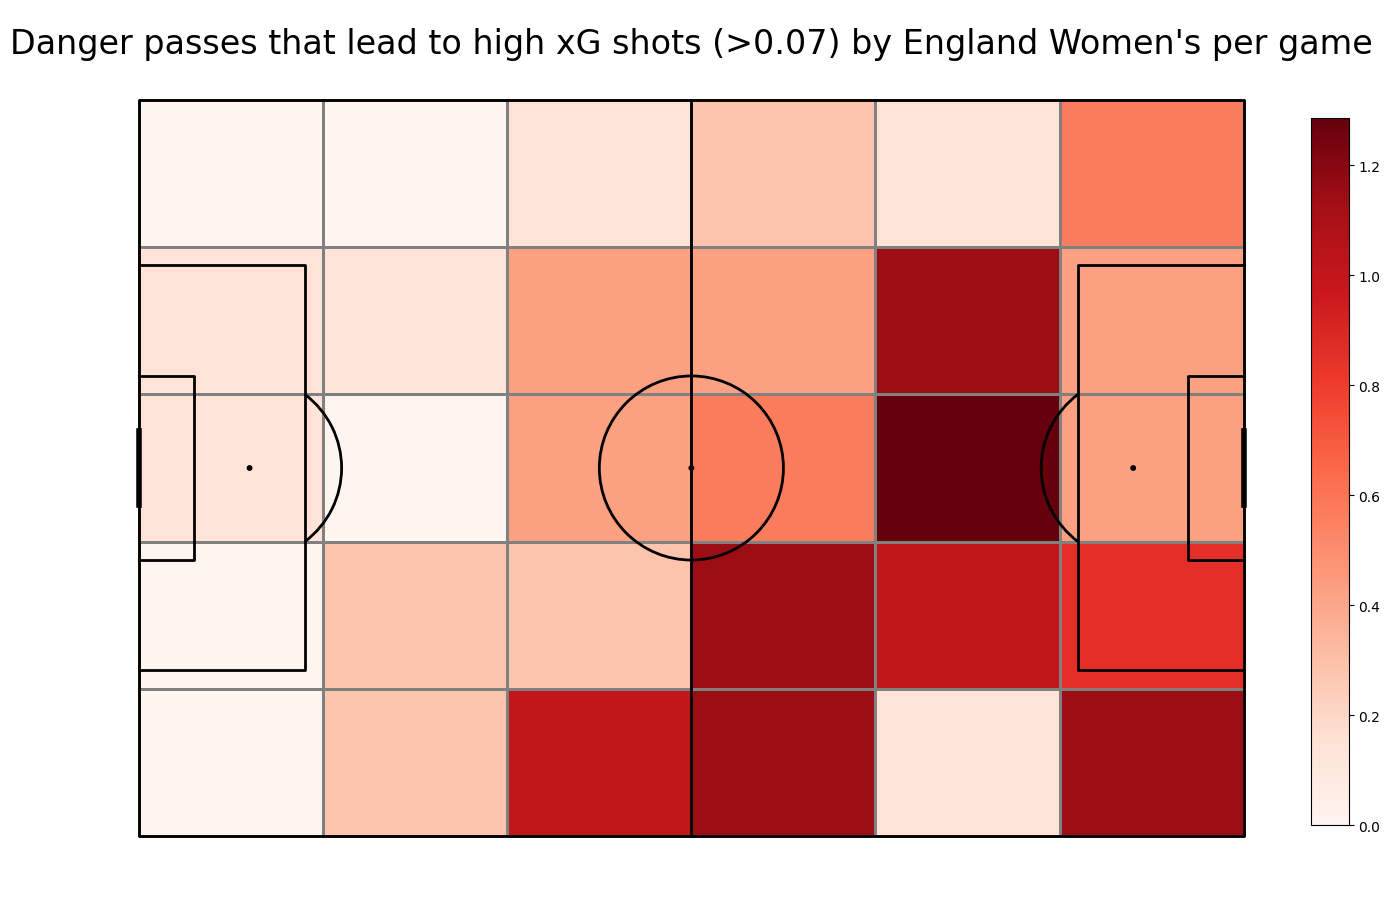

In [40]:
# Plot a vertical pitch.

pitch = Pitch(line_zorder=2, line_color='black')

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# get the 2D histogram.
bin_statistic = pitch.bin_statistic(
    danger_passes.x,
    danger_passes.y,
    statistic='count',
    bins=(6, 5),
    normalize=False
)

#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))

cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes that lead to high xG shots (>0.07) by ' + team + " per game", fontsize = 24)
plt.show()

### Heat Map for only Sweden's player who was the most involved in danger passes!

In [42]:
#open the data
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)
#our team
team = "Sweden Women's"
#get list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)

In [43]:
match_ids

[22944, 68345, 69163, 69301, 69208, 22973, 69284]

In [44]:
no_games

7

In [79]:
# Declare an empty dataframe.
danger_passes = pd.DataFrame()

for idx in match_ids:
    # open the event data from this game.
    df = parser.event(idx)[0]
    for period in [1, 2]:
        # Keep only accurate passes by england that were not set pieces in this period.
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())

        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

        # Keep only shots by england in this period.
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period) & (df.shot_statsbomb_xg > 0.07)

        # Keep only necessary columns.
        shots = df.loc[mask_shot, ['minute', 'second']]

        # Convery time to seconds.
        shot_times = shots['minute'] * 60 + shots['second']

        # 15 seconds window from the shot.
        shot_window = 15

        # condition to avoid negative shot starts.
        shot_start = shot_times - shot_window
        shot_start = shot_start.apply(lambda x: x if x > 0 else (period - 1) * 45)

        # convert to seconds
        pass_times = passes['minute'] * 60 + passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

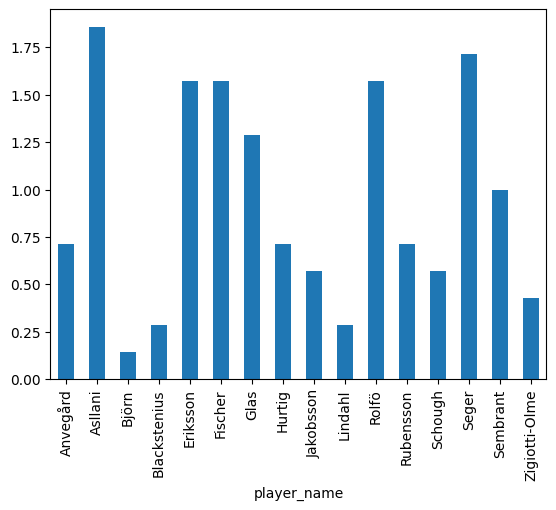

In [80]:
# Keep only surnames.
danger_passes['player_name'] = danger_passes['player_name'].apply(lambda x: str(x).split()[-1])

# count passes by player and normalize them.
pass_count = danger_passes.groupby(['player_name']).x.count()/no_games

# make a histogram.
ax = pass_count.plot.bar(pass_count)

In [85]:
most_involved_players = pass_count.sort_values(ascending=False)

In [86]:
monst_involved_danger_passes = danger_passes[(danger_passes['player_name'].apply(lambda x: x in most_involved_players.index.to_list()))]

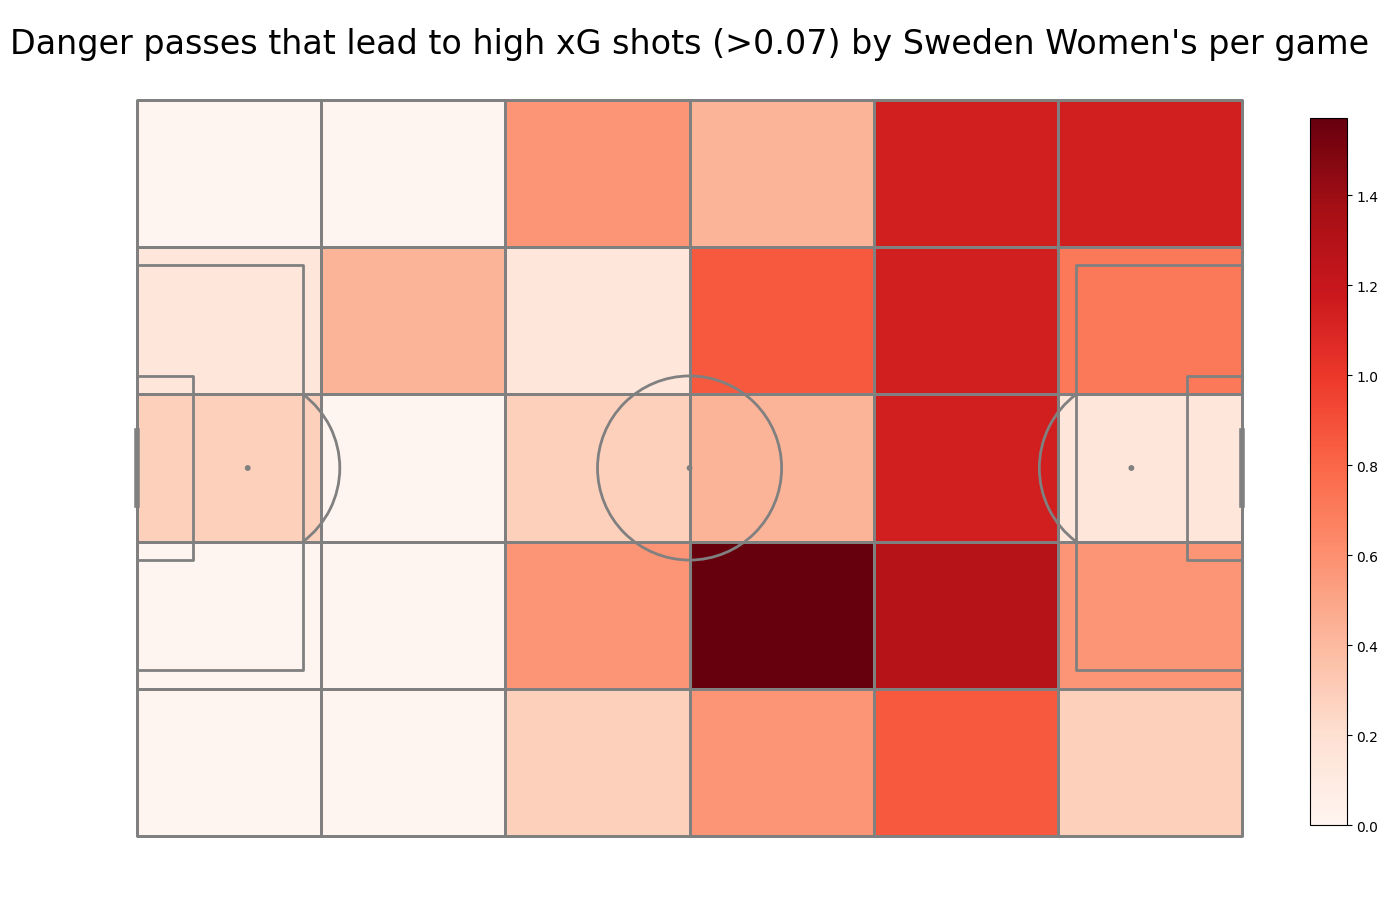

In [104]:
# Plot a vertical pitch.

pitch = Pitch(line_zorder=2, line_color='grey')

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# get the 2D histogram.
bin_statistic = pitch.bin_statistic(
    monst_involved_danger_passes.x,
    monst_involved_danger_passes.y,
    statistic='count',
    bins=(6, 5),
    normalize=False
)

#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))

cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes that lead to high xG shots (>0.07) by ' + team + " per game", fontsize = 24)
plt.show()